In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
import random
import math
%matplotlib inline

In [4]:
images_dir = "./images"
# list of all digits
digits = list(map(str, range(10))) + ["ba", "pa"]
# map digits to their respective directory path
digits_dir = dict(zip(digits, map(lambda d: os.path.join(images_dir, d), digits)))

In [5]:
total_images = sum(len(glob.glob(os.path.join(folder, "*.jpg"))) for _, folder in digits_dir.items())
total_images

2033

In [6]:
im_width = im_height = 128
batch_size = 32
validation_split = 0.3

datagen = ImageDataGenerator(rescale=1.0/255.0, 
                             validation_split=validation_split,
                             shear_range=0.2,
                             zoom_range=0.2,
                             rotation_range=10, 
#                              width_shift_range=0.2,
#                              height_shift_range=0.2,
                            )

train_gen = datagen.flow_from_directory(images_dir, target_size=(im_height, im_width), batch_size=batch_size, subset="training")
validation_gen = datagen.flow_from_directory(images_dir, target_size=(im_height, im_width), batch_size=batch_size, subset="validation")
train_steps_per_epoch = int(total_images * (1 - validation_split)) // batch_size
validation_steps_per_epoch = int(total_images * validation_split) // batch_size

Found 1430 images belonging to 12 classes.
Found 603 images belonging to 12 classes.


In [7]:
from keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Flatten
from keras.models import Model

def conv_block(inp, filters=32, bn=True, pool=True):
    _ = Conv2D(filters=filters, kernel_size=3, activation='relu')(inp)
    if bn:
        _ = BatchNormalization()(_)
    if pool:
        _ = MaxPool2D()(_)
    return _

input_img = Input(shape=(im_height, im_width, 3))
_ = conv_block(input_img, filters=32, bn=False, pool=False)
_ = conv_block(_, filters=32*2)
_ = conv_block(_, filters=32*3)
# _ = conv_block(_, filters=32*4)
# _ = conv_block(_, filters=32*5)
# _ = conv_block(_, filters=32*6)
_ = GlobalMaxPool2D()(_)
_ = Dense(units=128, activation="relu")(_)
_ = Dense(units=12, activation="softmax")(_)

model = Model(inputs=input_img, outputs=_)
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
model.save('number_plate_model.h5')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 64)      18496     
                                                                 
 batch_normalization (Batch  (None, 124, 124, 64)      256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 62, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 96)        55392 

D:\APPLICATIONS\Anaconda\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [8]:
history = model.fit_generator(train_gen, steps_per_epoch=train_steps_per_epoch, epochs=20, 
                              validation_data=validation_gen, validation_steps=validation_steps_per_epoch)

C:\Users\dell\AppData\Local\Temp\ipykernel_8624\740632642.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, steps_per_epoch=train_steps_per_epoch, epochs=20,


Epoch 1/20
44/44 [==============================] - 256s 6s/step - loss: 2.3154 - accuracy: 0.2783 - val_loss: 2.4793 - val_accuracy: 0.1095
Epoch 2/20
44/44 [==============================] - 220s 5s/step - loss: 1.1905 - accuracy: 0.6302 - val_loss: 2.4476 - val_accuracy: 0.1575
Epoch 3/20
44/44 [==============================] - 225s 5s/step - loss: 0.7349 - accuracy: 0.7861 - val_loss: 2.3978 - val_accuracy: 0.1758
Epoch 4/20
44/44 [==============================] - 238s 5s/step - loss: 0.5767 - accuracy: 0.8326 - val_loss: 2.0491 - val_accuracy: 0.2919
Epoch 5/20
44/44 [==============================] - 261s 6s/step - loss: 0.4248 - accuracy: 0.8777 - val_loss: 1.7644 - val_accuracy: 0.4892
Epoch 6/20
44/44 [==============================] - 244s 5s/step - loss: 0.3630 - accuracy: 0.8991 - val_loss: 1.5669 - val_accuracy: 0.5987
Epoch 7/20
44/44 [==============================] - 199s 5s/step - loss: 0.3026 - accuracy: 0.9106 - val_loss: 1.0477 - val_accuracy: 0.7114
Epoch 8/20
44

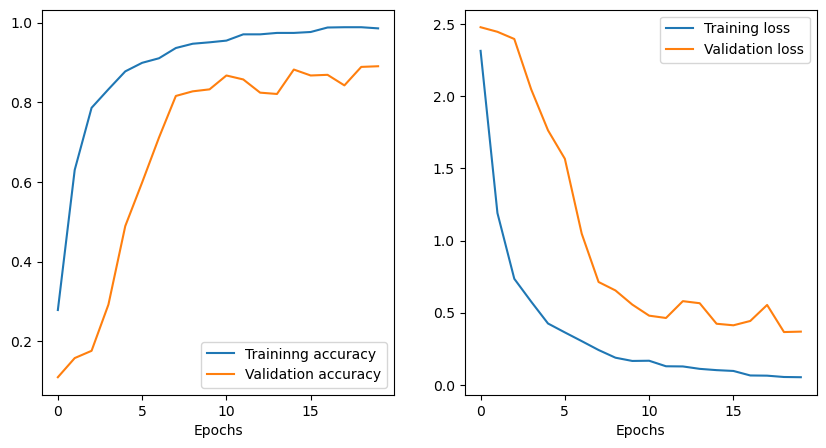

In [10]:
def plot_train_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].plot(history.history['accuracy'], label='Traininng accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Validation accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()


    axes[1].plot(history.history['loss'], label='Training loss')
    axes[1].plot(history.history['val_loss'], label='Validation loss')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

plot_train_history(history)

# Plot some predictions

In [11]:
X, Y_true = next(validation_gen)
Y_true = Y_true.argmax(axis=-1)
Y_pred = model.predict_on_batch(X).argmax(axis=-1)

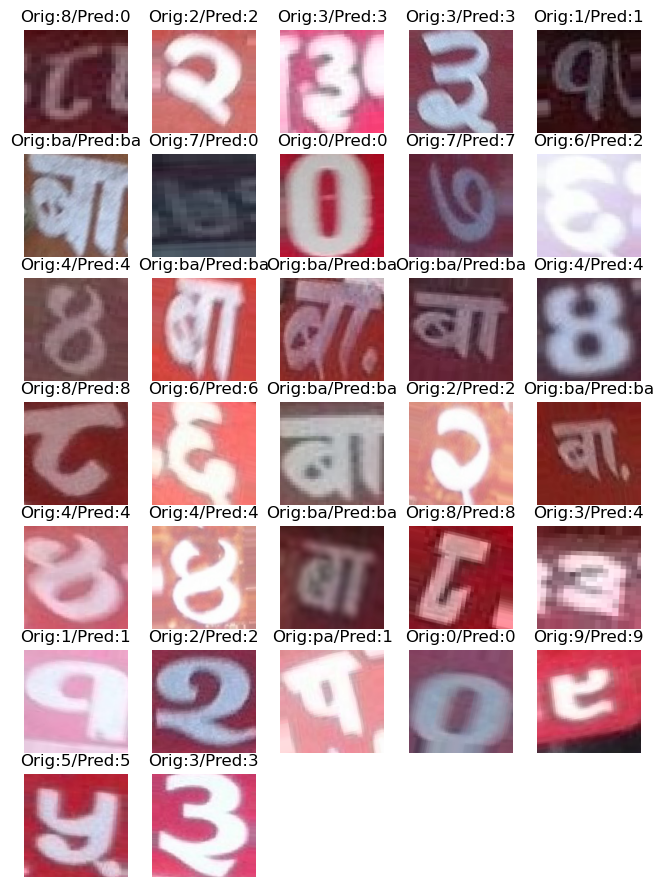

In [12]:
n_cols = 5
n_rows = math.ceil(len(X) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols+3, n_rows+4))
for i, (x, y_true, y_pred) in enumerate(zip(X, Y_true, Y_pred)):
    ax = axes.flat[i]
    ax.imshow(x, aspect='equal')
    ax.set_title("Orig:{}/Pred:{}".format(digits[y_true], digits[y_pred]))

for ax in axes.flat:
    ax.axis('off')

In [14]:
from sklearn.metrics import confusion_matrix
# Create a confusion matrix
confusion = confusion_matrix(Y_true, Y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion)

Confusion Matrix:
[[2 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0 0 0]
 [0 0 0 3 1 0 0 0 0 0 0 0]
 [0 0 0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 7 0]
 [0 1 0 0 0 0 0 0 0 0 0 0]]
